In [6]:
%matplotlib inline

import os
import sys
import copy
import numpy as np

# filtering Astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

sys.path.append('../lib/')
from hdmclouds_v1 import *
from utils import *
from graph import *
from preprocessing import *
#from gmr_ import *
from gmr import *

from ipywidgets import interact, interactive, fixed, FloatSlider, IntSlider
import matplotlib
import matplotlib.pyplot as plt; plt.show()
matplotlib.rcParams.update({'font.size': 13})

from pycupid import *
import astropy.units as u
from astropy.visualization import AsymmetricPercentileInterval

save_path = "/Users/martin/Dropbox/Aplicaciones/ShareLaTeX/HDMC-v1/figures/"

***

In [7]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

def load_data(fits_path):
    hdu = fits.open(fits_path)[0]
    data = hdu.data
    wcs = WCS(hdu.header)

    if data.ndim>3:
        # droping out the stokes dimension
        data = np.ascontiguousarray(data[0])
        wcs = wcs.dropaxis(3)

        if data.shape[0]==1:
            # in case data is not a cube but an image
            data = np.ascontiguousarray(data[0])
            wcs = wcs.dropaxis(2)
    
    # in case NaN values exist on data
    mask = np.isnan(data)
    if np.any(mask): data = ma.masked_array(data, mask=mask)

    return data,wcs,hdu

In [1]:
from spectral_cube import SpectralCube

In [4]:
cube = SpectralCube.read(fits_path)

ValueError: No spectral axes found in WCS

In [8]:
fits_path = "../data/SCIMES/orion_12CO.fits"
data,wcs,hdu = load_data(fits_path)

print(wcs)
print("\nShape of array:", data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-CAR'  'GLAT-CAR'  'M/S'  
CRVAL : 226.0  -25.0  46485.9924316  
CRPIX : 1.0  1.0  1.0  
NAXIS : 209  177  150

Shape of array: (150, 177, 209)


In [11]:
wcs.axis_type_names

['GLON', 'GLAT', 'M/S']

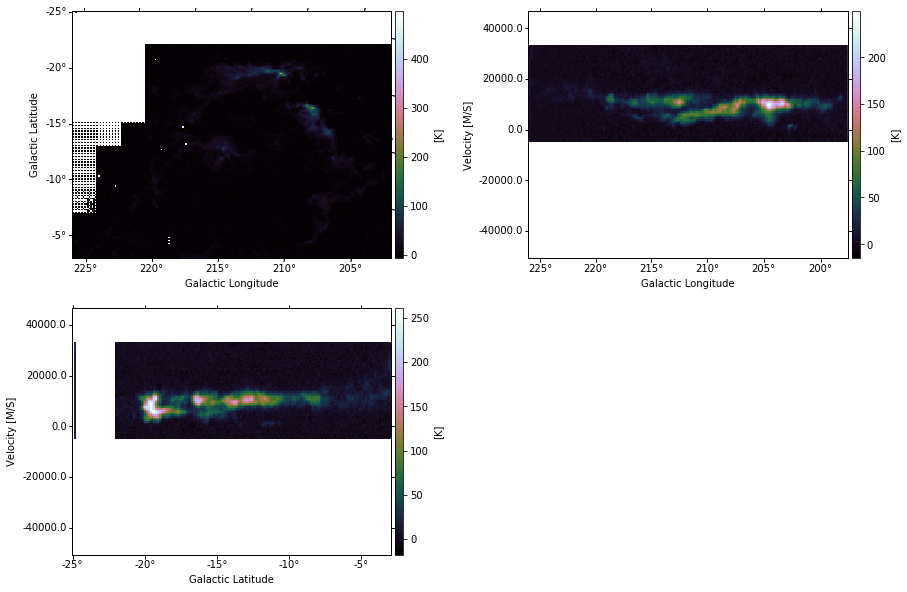

In [13]:
cube_plot(data, wcs=wcs, unit=hdu.header["BUNIT"])

In [13]:
%%prun -s tottime -q -l 30 -T gmr_v0_prof
rms = estimate_rms(data)
hdmc = HDMClouds(data, back_level=rms, wcs=wcs, verbose=False, n_center=500)

../lib/preprocessing.py:20: RuntimeWarning: invalid value encountered in greater_equal
  mask = data>=back_level


[INFO] Number of usable pixels: 8320
 
*** Profile printout saved to text file 'gmr_v0_prof'. 


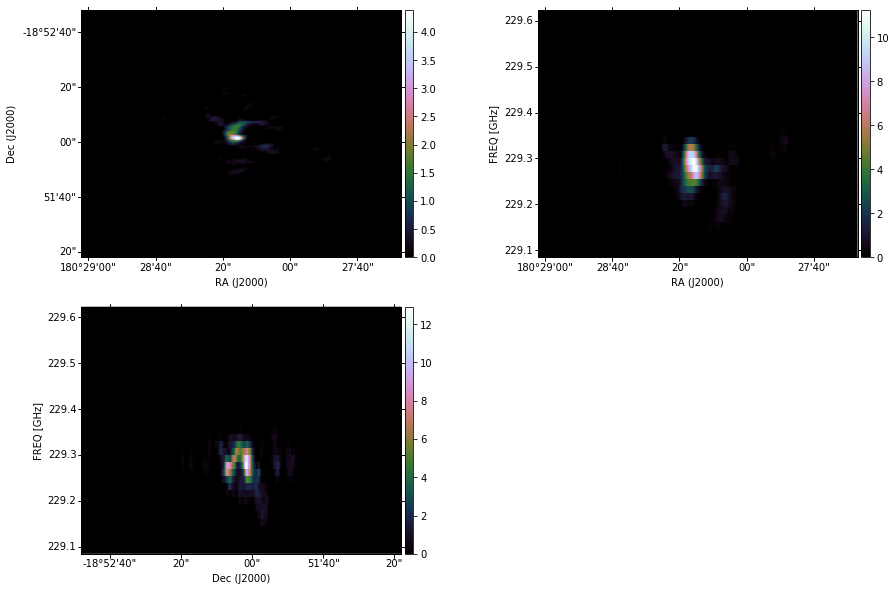

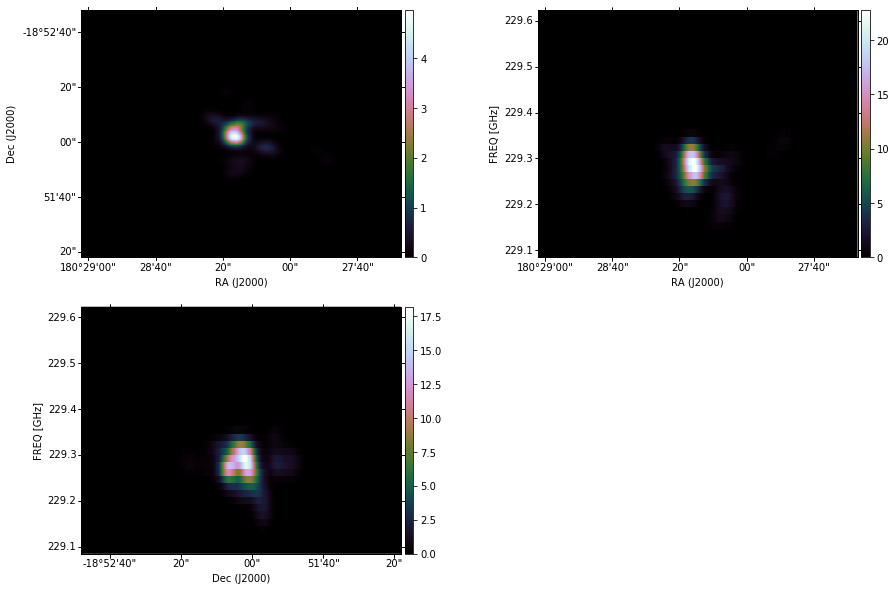

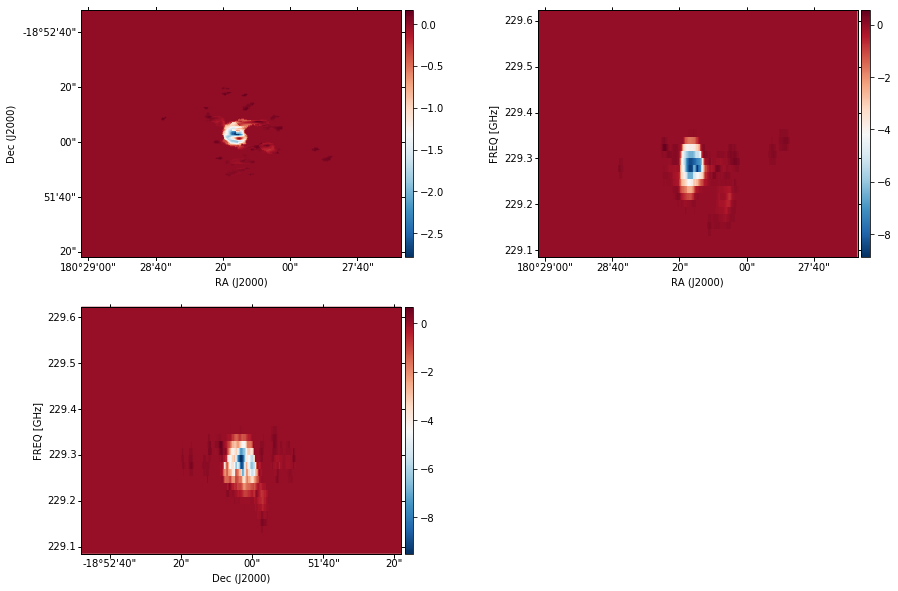

RESIDUAL STATS
RMS of residual: 0.007528540142331074
Inf norm of residual: 0.6540578941701221
Variance of residual: 5.6633555738599756e-05
Normalized flux addition: 0.7179587252642714
Normalized flux lost: 0.05720414674608493


In [14]:
hdmc.get_residual_stats();

## Profiling Results

In [20]:
print(open('gmr_v0_prof', 'r').read())

         133915727 function calls (133881651 primitive calls) in 508.436 seconds

   Ordered by: internal time
   List reduced from 1567 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1  212.930  212.930  212.930  212.930 {fgm_eval.gm_eval3d_1}
    16811  103.426    0.006  103.426    0.006 gmr.py:211(less_dissimilar)
    16811   49.010    0.003   49.010    0.003 gmr.py:262(update_structs)
   273331   32.512    0.000   32.512    0.000 {built-in method numpy.core.multiarray.array}
        2   25.567   12.783  103.316   51.658 utils.py:185(compute_neighbors)
   411202   19.668    0.000   19.668    0.000 {method 'sort' of 'list' objects}
128371819   12.307    0.000   12.307    0.000 {method 'append' of 'list' objects}
    16815    9.865    0.001   11.021    0.001 {method 'query_radius' of 'sklearn.neighbors.ball_tree.BinaryTree' objects}
   411200    8.878    0.000    8.878    0.000 {method 'tolist' of 'numpy.ndarray' objects}

In [14]:
print(open('gmr_v0_prof', 'r').read())

         72995042 function calls (72960640 primitive calls) in 1058.946 seconds

   Ordered by: internal time
   List reduced from 1566 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    17192  708.139    0.041  708.139    0.041 gmr.py:211(less_dissimilar)
    17192  173.784    0.010  173.784    0.010 gmr.py:262(update_structs)
        1   80.878   80.878   80.878   80.878 {fgm_eval.gm_eval3d_1}
        2   22.462   11.231   22.462   11.231 gmr.py:198(build_diss_matrix)
      6/2    9.953    1.659   12.012    6.006 gmr.py:177(_compute_neighbors)
        2    9.396    4.698   27.927   13.963 utils.py:175(compute_neighbors)
    17196    7.817    0.000    8.872    0.001 {method 'query_radius' of 'sklearn.neighbors.ball_tree.BinaryTree' objects}
   276627    6.220    0.000    6.220    0.000 {built-in method numpy.core.multiarray.array}
   410402    5.861    0.000    5.861    0.000 {method 'sort' of 'list' objects}
        2    4.866  

In [7]:
# this is the result for gmr_ module: The one that keeps the dissimilarity array sorted
print(open('gmr_v0_prof', 'r').read())

         72994532 function calls (72960130 primitive calls) in 6384.163 seconds

   Ordered by: internal time
   List reduced from 1567 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    17192 3319.574    0.193 3319.574    0.193 gmr.py:211(less_dissimilar)
    34396 2744.918    0.080 2745.433    0.080 {method 'sum' of 'numpy.ndarray' objects}
    17192  162.305    0.009  162.305    0.009 gmr.py:262(update_structs)
        1   68.710   68.710   68.710   68.710 {fgm_eval.gm_eval3d_1}
        2   20.136   10.068   20.136   10.068 gmr.py:198(build_diss_matrix)
        2    9.179    4.589   26.920   13.460 utils.py:175(compute_neighbors)
      6/2    8.584    1.431   10.321    5.161 gmr.py:177(_compute_neighbors)
    17196    7.638    0.000    8.552    0.000 {method 'query_radius' of 'sklearn.neighbors.ball_tree.BinaryTree' objects}
   410402    5.779    0.000    5.779    0.000 {method 'sort' of 'list' objects}
   276627    5.463    0.

In [60]:
# this is the result for the gmr_ module (no sorted klarray) without any optimization
print(open('gmr_v0_prof', 'r').read())

         73037988 function calls (72971288 primitive calls) in 4189.365 seconds

   Ordered by: internal time
   List reduced from 1889 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    17192 3574.077    0.208 3574.077    0.208 gmr.py:323(update_structs)
    17192  388.048    0.023  388.048    0.023 gmr.py:264(least_dissimilar)
        1   76.208   76.208   76.208   76.208 {fgm_eval.gm_eval3d_1}
        2   59.987   29.993   59.987   29.993 gmr.py:251(build_diss_matrix)
      6/2   20.140    3.357   21.754   10.877 gmr.py:229(_compute_neighbors)
    17196   11.610    0.001   12.574    0.001 {method 'query_radius' of 'sklearn.neighbors.ball_tree.BinaryTree' objects}
        2   11.230    5.615 4084.614 2042.307 gmr.py:369(mixture_reduction)
        2    9.366    4.683   28.084   14.042 utils.py:175(compute_neighbors)
   410408    6.096    0.000    6.096    0.000 {method 'sort' of 'list' objects}
   242237    5.728    0.000    5.72

## GM parameters optimization

In [15]:
hdmc.build_gmr()

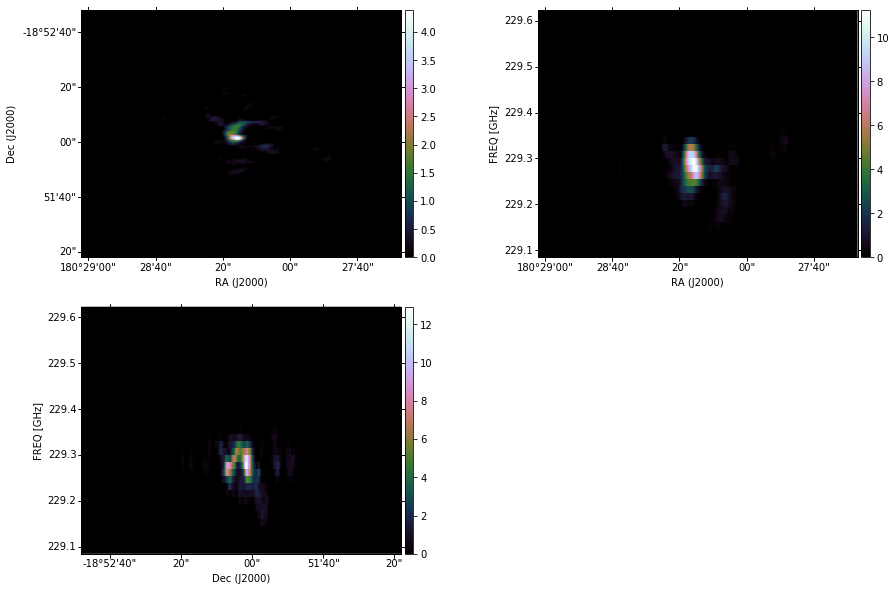

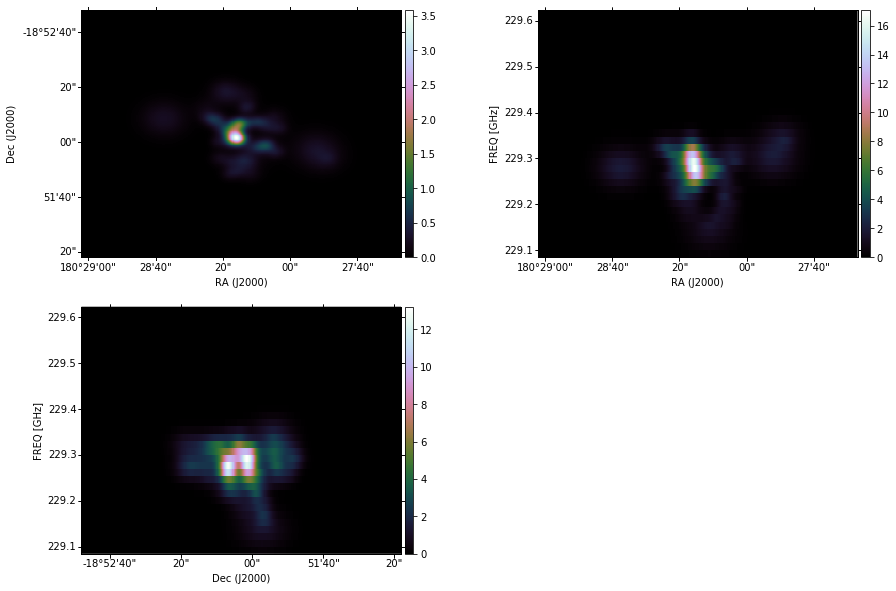

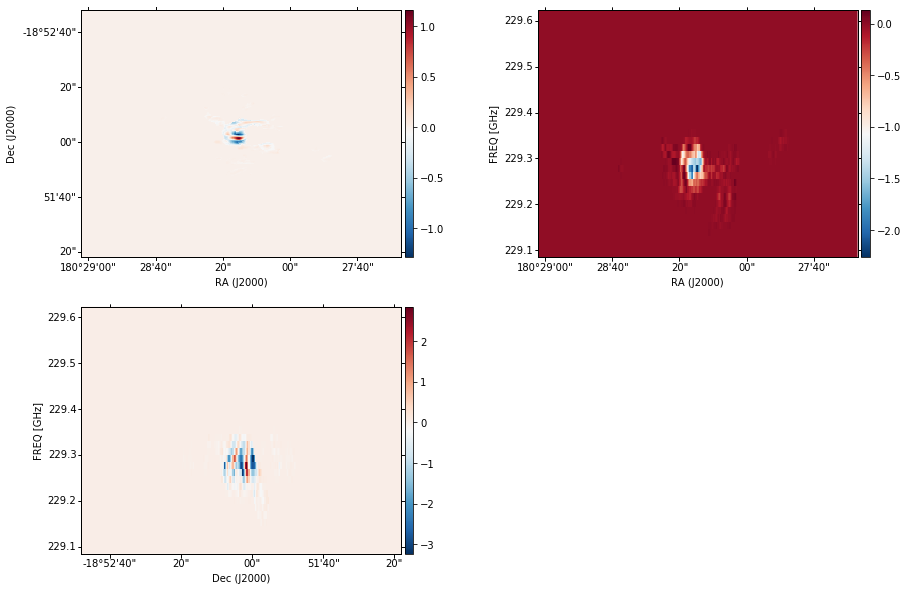

RESIDUAL STATS
RMS of residual: 0.002977913473813679
Inf norm of residual: 0.3112060638126627
Variance of residual: 8.86675146553361e-06
Normalized flux addition: 0.1895253980730779
Normalized flux lost: 0.08128765713463176


In [16]:
hdmc.get_residual_stats(plot=True);

In [17]:
hdmc.solver_output()

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 200200.
nfev: 200214
xtol: 1e-07
ftol: 1e-07


In [18]:
print("Elapsed time {0}".format(hdmc.elapsed_time))

Elapsed time 1151.960999250412


In [19]:
w,sig = hdmc.get_params_mapped()

print("PARAMETERS VARIATION:")
print("w variation: ",np.max(np.abs(hdmc.w0-w)))
print("sig variation: ",np.max(np.abs(hdmc.sig0-sig)))

PARAMETERS VARIATION:
w variation:  0.3101899379186617
sig variation:  0.050257653807611685


***
***